**<div style="text-align:right"> Fichier d'expériences</div>**
*<div style="text-align:right"> Djinny Volet <br> M2 Informatique </div>*

---

Expériences menées en Python 3.5.2 avec les bibliothèques suivantes

* pandas
* numpy
* matplotlib
* pydotplus
* scikit-learn
* theano
* keras

---

# Partie 1 : Approche du sujet et des données *(16 Novembre)*

## Vue d'ensemble

Nous nous sommes attachés dans un premier temps à comprendre le sujet, les données, et les premières pistes d'explorations possibles

* Données : [Glass Identification Data Set @ UCI Repository](https://archive.ics.uci.edu/ml/datasets/Glass+Identification)
* Utiliser des méthodes pour faire de la classification sur des morceaux de verres recueillis sur scène de crime
* Les données sont livrées avec leurs étiquettes : possibilité d'utiliser des méthodes supervisées
* Methodes possibles : *K Nearest Neighbors, Multi-Layer Perceptron, Support Vector Machine, méthodes ensemblistes*

<br>
Ainsi que des objectifs

* Obtenir la classification la plus sûre possible
* débusquer le classifieur le plus efficace possible et ses conditions d'utilisation optimales
* Rendre compte le plus clairement possible des expériences menées

## Chargement des données

Pour mieux manipuler nos données brutes, nous les avons importer dans une représentation similaire à celle des bases de données.

In [1]:
import pandas as pd

columns = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca','Ba', 'Fe', 'Class']
classes = ['1', '2', '3', '5', '6', '7']
glass = pd.read_csv('Data/glass.csv', index_col = 0, names = columns)
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Nous séparons la matrice des vecteurs de caractéristiques et des classes pour faciliter la manipulation des bibliothèques. Nous en profitons pour observer la répartition des exemples de la base entière sur les classes et remarquons qu'il n'y en a aucun pour représenter la classe 4.

In [2]:
X = glass.iloc[:, 0:9]
y = glass.iloc[:, 9]
y.value_counts(sort=False)

1    70
2    76
3    17
5    13
6     9
7    29
Name: Class, dtype: int64

## Separation en base d'apprentissage et de test

En prévision des différentes modélisations statistiques à venir, nous séparons notre jeu de données en **base d'apprentissage** et en **base de test**, avec un ratio **70/30**. Puis nous vérifions que les classes ont été réparties dans des proportions similaires.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 50)
print("Répartition de classes dans la base d'apprentissage")
print(y_train.value_counts(sort=False))
print("\nRépartition de classes dans la base de test")
print(y_test.value_counts(sort=False))

Répartition de classes dans la base d'apprentissage
1    51
2    52
3    12
5     8
6     6
7    20
Name: Class, dtype: int64

Répartition de classes dans la base de test
1    19
2    24
3     5
5     5
6     3
7     9
Name: Class, dtype: int64


---

# Partie 2 : Pre-processing et premier modèle *(21 Novembre)*

## Normalisation des données

Afin de s'adapter aux besoins des différents classifieurs, nous normalisons les différents vecteurs de caractéristiques suivant plusieurs méthodes
* Variable centrée réduite
* Dans l'intervalle `[-1, 1]`

In [4]:
from sklearn.preprocessing import StandardScaler, maxabs_scale 

# Variable centrée réduite
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Dans l'intervalle [-1, 1]
X_train_scale = maxabs_scale(X_train)
X_test_scale = maxabs_scale(X_test)

## Partage des données

Afin que l'ensemble des étudiants du groupe de projet se retrouve avec les mêmes données, je recopie les bases d'apprentissages et de tests sous format `.csv`, dans chacune des méthodes de normalisation possible.

In [5]:
# Données brutes
x1 = pd.DataFrame(X_train, columns = columns[:-1])
x1['Class'] = y_train.values
x1.to_csv("data/raw_train.csv", index = False)

x2 = pd.DataFrame(X_test, columns = columns[:-1])
x2['Class'] = y_test.values
x2.to_csv("data/raw_test.csv", index = False)

# Données centrées réduites
x3 = pd.DataFrame(X_train_norm, columns = columns[:-1])
x3['Class'] = y_train.values
x3.to_csv("data/norm_train.csv", index = False)

x4 = pd.DataFrame(X_test_norm, columns = columns[:-1])
x4['Class'] = y_test.values
x4.to_csv("data/norm_test.csv", index = False)

# Données dans [-1, 1]
x5 = pd.DataFrame(X_train_scale, columns = columns[:-1])
x5['Class'] = y_train.values
x5.to_csv("data/scale_train.csv", index = False)

x6 = pd.DataFrame(X_test_scale, columns = columns[:-1])
x6['Class'] = y_test.values
x6.to_csv("data/scale_test.csv", index = False)

## Classification : méthode KNN

Pour commencer nos classifications nous utilisons un classifieur simple : celui des plus proches voisins. Pour chaque type de données (brutes, centrées normalisées, sur intervalle `[-1,1]`), nous allons jouer sur deux paramètres.
* Le nombre de voisins pris en compte
* L'influence de la distance sur le poids du vote des voisins

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

r = list(range(1, 18, 2)) # valeurs de k a tester
weights = ['uniform', 'distance']
raw = np.zeros((2, len(r)))
norm = np.zeros((2, len(r)))
scale = np.zeros((2, len(r)))

### KNN : données brutes

In [7]:
i = 0
for w in weights:
    j = 0
    for k in r:
        neigh = KNeighborsClassifier(n_neighbors = k, algorithm = 'auto', weights = w, n_jobs=-1)
        neigh.fit(X_train, np.ravel(y_train))
        raw[i, j] = neigh.score(X_test, y_test)
        j += 1
    i += 1

### KNN : données centrées réduites

In [8]:
i = 0
for w in weights:
    j = 0
    for k in r:
        neigh = KNeighborsClassifier(n_neighbors = k, algorithm = 'auto', weights = w, n_jobs=-1)
        neigh.fit(X_train_norm, np.ravel(y_train))
        norm[i, j] = neigh.score(X_test_norm, y_test)
        j += 1
    i += 1

### KNN : données dans [-1, 1]

In [9]:
i = 0
for w in weights:
    j = 0
    for k in r:
        neigh = KNeighborsClassifier(n_neighbors = k, algorithm = 'auto', weights = w, n_jobs=-1)
        neigh.fit(X_train_scale, np.ravel(y_train))
        scale[i, j] = neigh.score(X_test_scale, y_test)
        j += 1
    i += 1

### KNN : résultats *(28 Novembre)*
Enfin, on observe nos résultats à l'aide de graphiques.

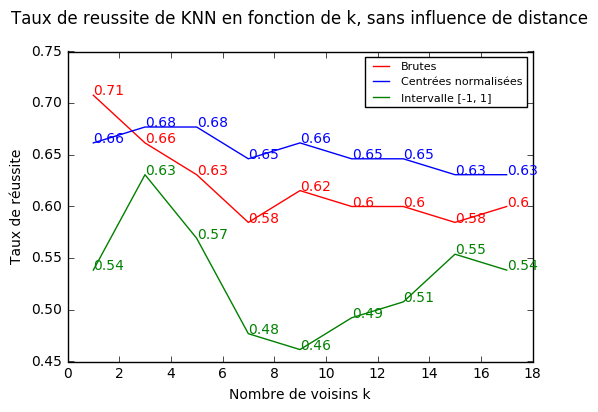

In [10]:
from matplotlib import pyplot as plt

# Affichage des courbes
plt.plot(r, raw[0, :], color = 'r', label = 'Brutes')
plt.plot(r, norm[0, :], color = 'b', label = 'Centrées normalisées')
plt.plot(r, scale[0, :], color = 'g', label = 'Intervalle [-1, 1]')
plt.xlabel('Nombre de voisins k')
plt.ylabel('Taux de réussite')
plt.title('Taux de reussite de KNN en fonction de k, sans influence de distance\n')

# Affichage des points
for n in range(len(r)): 
    plt.text(r[n], raw[0,n], str(round(raw[0,n],2)), color = 'r')
    plt.text(r[n], norm[0,n], str(round(norm[0,n],2)), color = 'b')
    plt.text(r[n], scale[0,n], str(round(scale[0,n],2)), color = 'g')

# Affichage de la legende et du graphe
plt.legend(loc = 'best', prop={'size':'8'})
plt.show()

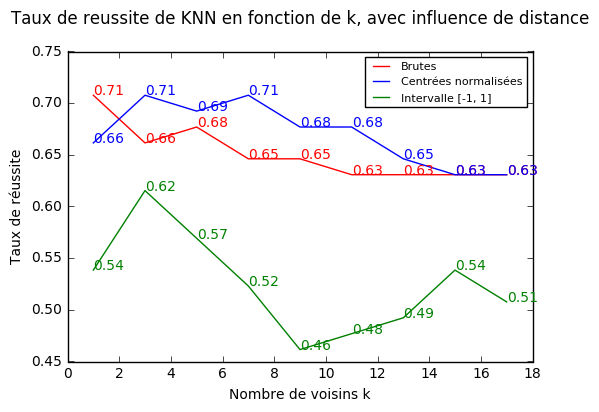

In [11]:
from matplotlib import pyplot as plt
plt.plot(r, raw[1, :], color = 'r', label = 'Brutes')
plt.plot(r, norm[1, :], color = 'b', label = 'Centrées normalisées')
plt.plot(r, scale[1, :], color = 'g', label = 'Intervalle [-1, 1]')
plt.xlabel('Nombre de voisins k')
plt.ylabel('Taux de réussite')
plt.title('Taux de reussite de KNN en fonction de k, avec influence de distance\n')

for n in range(len(r)): 
    plt.text(r[n], raw[1,n], str(round(raw[1,n],2)), color = 'r')
    plt.text(r[n], norm[1,n], str(round(norm[1,n],2)), color = 'b')
    plt.text(r[n], scale[1,n], str(round(scale[1,n],2)), color = 'g')

plt.legend(loc = 'best', prop={'size':'8'})
plt.show()

---

# Partie 3 : Recherches de méthodes *(28 Novembre)*

Au cours de cette séance nous essayons plusieurs classifieurs de manière naïve, afin de trouver ceux qui pourraient s'adapter au mieux à notre jeu de données.

## Regression Logistique

In [12]:
from sklearn.linear_model import LogisticRegressionCV

lrc = LogisticRegressionCV(fit_intercept = False, cv = 2, solver='lbfgs', n_jobs = -1)
lrc.fit(X_train_norm, y_train)
lrc.score(X_test_norm, y_test)

0.70769230769230773

## Support Vector Machine

In [13]:
from sklearn.svm import SVC

svc = SVC(kernel = 'rbf', C = 1.4)
svc.fit(X_train_norm, y_train)
svc.score(X_test_norm, y_test)

0.72307692307692306

Nous remarquons que ces deux classifieurs ont une performance à peu près équivalente sur nos données centrées réduites.

## Multi-Layer Perceptron

Pour ce classifieur, nous ne testerons qu'avec nos données qui ont déjà subies une normalisation, comme il est coutume avec les réseaux de neurones. Pour chaque type de données, nous affichons la distribution du taux de succès sur 100 essais, pour tenter de réduire l'effet aléatoire et observer les tendances globales. Nous affichons aussi le score median.

### Données centrées réduites

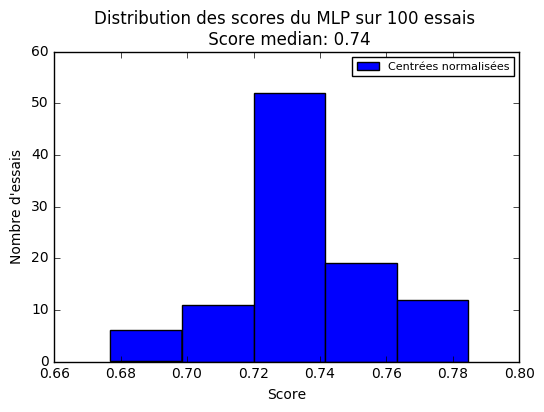

In [14]:
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt

scores = []
for i in range(100):
    mlp = MLPClassifier(hidden_layer_sizes=(30,), learning_rate_init = 0.03, solver = 'sgd',
                        max_iter = 5000)
    mlp.fit(X_train_norm, y_train)
    scores.append(mlp.score(X_test_norm, y_test))
    #print(i,':\t',mlp.n_iter_)
mediane = round(np.median(scores), 2)

plt.figure()
plt.hist(scores, bins=5, color = 'b', label = 'Centrées normalisées')
plt.title('Distribution des scores du MLP sur 100 essais \n Score median: '+str(mediane))
plt.xlabel('Score')
plt.ylabel("Nombre d'essais")
plt.legend(loc = 'best', prop={'size':'8'})
plt.show()

### Données dans `[-1,  1]`

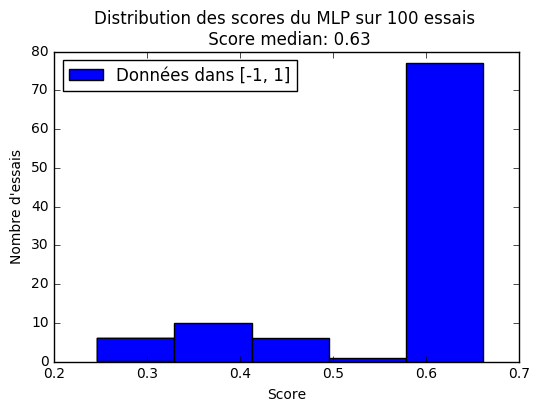

In [15]:
scores = []
for i in range(100):
    mlp = MLPClassifier(hidden_layer_sizes=(30,), activation='tanh', learning_rate_init = 0.1, solver = 'sgd',
                        max_iter = 5000)
    mlp.fit(X_train_scale, y_train)
    scores.append(mlp.score(X_test_scale, y_test))
    #print(i,':\t',mlp.n_iter_)
mediane = round(np.median(scores), 2)

plt.figure()
plt.hist(scores, bins=5, color = 'b', label = 'Données dans [-1, 1]')
plt.title('Distribution des scores du MLP sur 100 essais \n Score median: '+str(mediane))
plt.xlabel('Score')
plt.ylabel("Nombre d'essais")
plt.legend(loc = 'best')
plt.show()

---

# Partie 4 : Multi-Layer perceptron *(30 Novembre)*

Ici, notre but est d'implémenter un MLP encore une fois, mais cette fois-ci de telle sorte que les vecteurs de classes de sorties soient sous la forme : 1 pour l'index effectif de l'exemple, -1 pour le reste.
On souhaite également observer l'évolution des scores sur la base d'apprentissage et de test et fur et à mesure des passes, et ce avec différents learning rates.

On commence à importer les bibliothèques utiles

In [16]:
import theano
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import Callback

Using Theano backend.


Puis on adapte nos vecteurs et matrices de données avec un format dédié pour accélérer le traitement de nos données. On fait également la conversion de nos vecteurs de classes.

In [17]:
# Formattage
X_train_t = X_train_scale.astype(theano.config.floatX)
X_test_t = X_test_scale.astype(theano.config.floatX)

# Encodage des vecteurs de sortie
y_train_ohe = np_utils.to_categorical(y_train.values)
y_test_ohe = np_utils.to_categorical(y_test.values)
np.place(y_train_ohe, y_train_ohe == 0, -1)
np.place(y_test_ohe, y_test_ohe == 0, -1)

On créé enfin l'architecture de notre réseau. On pose 30 neurones sur la couche cachée, et le choix de la fonction d'activation `tanh`, dont les valeurs sont comprises dans l'intervalle `[-1, 1]`.

In [18]:
model = Sequential()
hidden_nodes = 30

model.add(Dense(input_dim=X_train_scale.shape[1],
                output_dim=hidden_nodes,
                init='uniform',
                activation='tanh'))

model.add(Dense(input_dim=hidden_nodes,
                output_dim=y_train_ohe.shape[1],
                init='uniform',
                activation='tanh'))

Puis, pour chacune des valeurs de learning rate proposée (`0.01, 0.03, 0.1, 0.3`) on effectue 1000 passes.

In [19]:
# Fonction pour récupérer les scores du training set et du testing set
class AccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.accs = []

    def on_batch_end(self, batch, logs={}):
        self.accs.append(logs.get('acc'))

        
lrs = [0.01, 0.03, 0.1, 0.3]
train_scores = []
test_scores = []
for lr in lrs:
    sgd = SGD(lr=0.3)
    model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
    history = AccHistory()
    k = model.fit(X_train_scale, 
              y_train_ohe,
              nb_epoch=1000, 
              verbose=0,
              validation_data = (X_test_t, y_test_ohe),
              callbacks=[history])
    train_scores.append(k.history['acc'])
    test_scores.append(k.history['val_acc'])

Enfin, on observe l'evolution des taux de succès pour chaque learning rate des données d'apprentissage et de test.

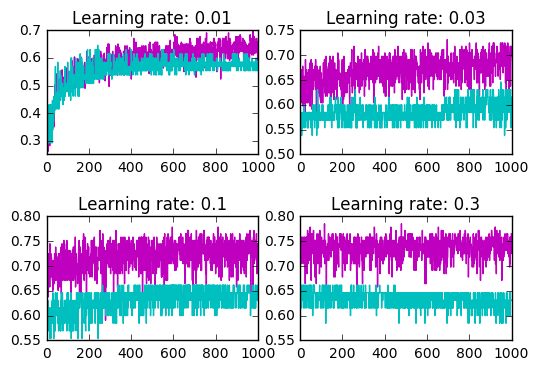

In [20]:
from matplotlib import pyplot as plt

plt.figure()
f, ((plt1, plt2), (plt3, plt4)) = plt.subplots(2, 2)
f.subplots_adjust(hspace = .5)

plt1.plot(train_scores[0], color = 'm', label = 'Training set')
plt1.plot(test_scores[0], color = 'c', label = 'Testing set')
plt1.set_title('Learning rate: '+str(lrs[0]))

plt2.plot(train_scores[1], color = 'm', label = 'Training set')
plt2.plot(test_scores[1], color = 'c', label = 'Testing set')
plt2.set_title('Learning rate: '+str(lrs[1]))

plt3.plot(train_scores[2], color = 'm', label = 'Training set')
plt3.plot(test_scores[2], color = 'c', label = 'Testing set')
plt3.set_title('Learning rate: '+str(lrs[2]))

plt4.plot(train_scores[3], color = 'm', label = 'Training set')
plt4.plot(test_scores[3], color = 'c', label = 'Testing set')
plt4.set_title('Learning rate: '+str(lrs[3]))

plt.show()

---

# Partie 5 : Arbre de décision et Random Forest

## Decision tree *(14 Décembre)*

Dans notre recherche de classifieur supplémentaire à tester pour augmenter le taux de succès de notre classification, nous essayons l'arbre de décision sur l'idée de Reynald Eugénie.

In [21]:
from sklearn import tree
dtree = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 50)
dtree.fit(X_train, y_train)

dtree.score(X_test, y_test)

0.75384615384615383

Confusion matrix, without normalization
[[14  2  3  0  0  0]
 [ 2 22  0  0  0  0]
 [ 2  2  1  0  0  0]
 [ 0  1  0  4  0  0]
 [ 0  1  0  0  2  0]
 [ 0  1  0  2  0  6]]


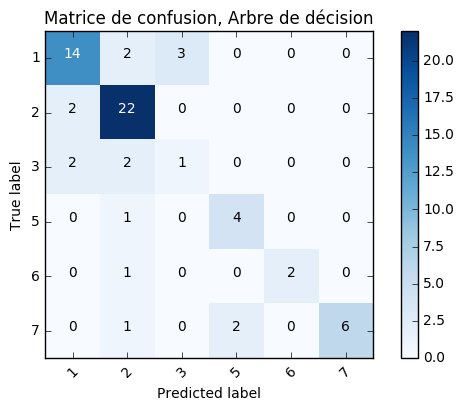

In [31]:
from sklearn.metrics import confusion_matrix
from plot_confusion_matrix import plot_confusion_matrix

cnf_matrix = confusion_matrix(y_test,dtree.predict(X_test))
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes, title = 'Matrice de confusion, Arbre de décision')
plt.show()

Nous pouvons observer sur la matrice de confusion ci-dessous que la plupart des exemples ont été bien classifiés. Pour une meilleure interprétabilité, nous crééons une visualision de l'arbre. Chaque couleur correspond à classe : plus la couleur est foncée, plus la probabilité qu'une feuille soit une règle pour une classe est renforcée.

Pour plus de lisibilité, l'arbre est disponible dans un fichier `.pdf` joint.

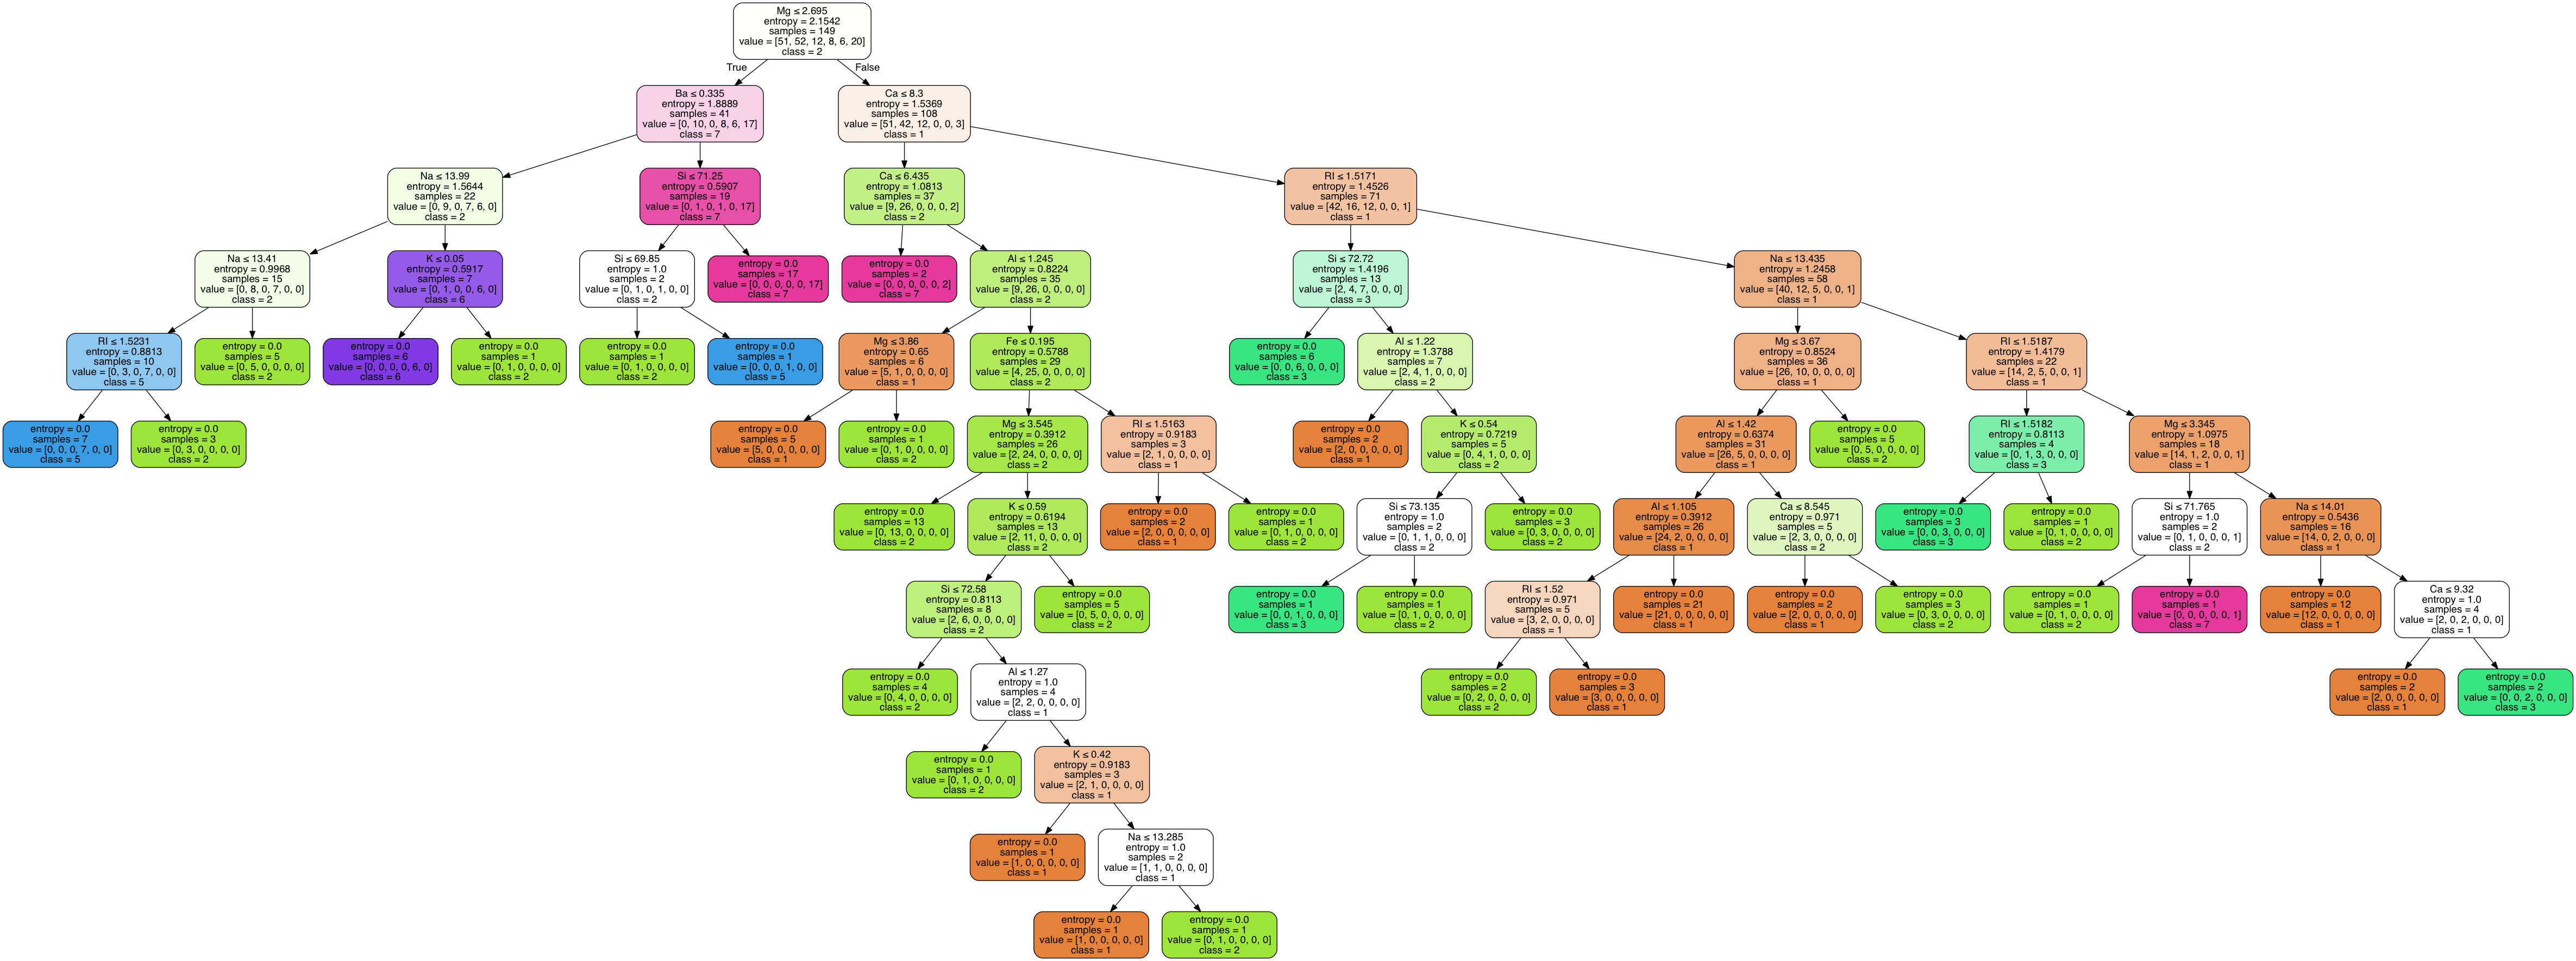

In [32]:
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(dtree, out_file = None, feature_names = columns, class_names=classes,
                                special_characters = True, filled = True, rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data)

# Creer un fichier de l'arbre en pdf
graph.write_pdf("tree.pdf")

# Afficher l'arbre dans la console courante
Image(graph.create_png())

## Modèle ensembliste : Random Forest *(17 Décembre)*

Pour tenter d'aller plus loin que nos arbres de décision, en dernier classifieur nous essayons le Random Forest. Vu qu'il existe plusieurs paramètres réglables pour ajuster au mieux notre classifieur à notre jeu de données, notre première mission sera de trouver les paramètres optimaux grâce à une cross-validation (ici, 3-fold cross-validation).



Les paramètres sur lesquels nous jouons sont :
* le nombre d'arbres "votant"
* le nombre maximum de caractéristiques que chaque arbre voteur peut voir
* le nombre minimal de d'exemples dans une feuille

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(n_jobs=-1)

param_grid = {"max_features":['sqrt', 1.0], 
              "n_estimators":[20, 100, 500], 
              "min_samples_leaf": [1, 0.05]}

grid_search = GridSearchCV(clf, cv=3, param_grid=param_grid)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}

Maintenant que nous avons trouvé les paramètres optimaux pour notre classifieur, nous faisons 200 essais afin de d'observer la distribution des scores et leur médiane.

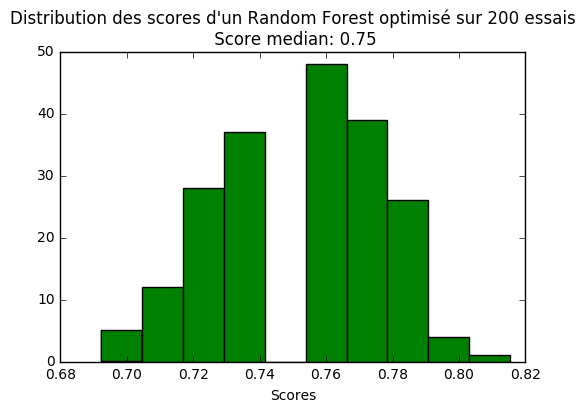

In [37]:
from matplotlib import pyplot as plt
import numpy as np

params = grid_search.best_params_
scores = []
for i in range(200):
    rf = RandomForestClassifier(criterion='gini',
                                max_features=params['max_features'],
                                n_estimators = params['n_estimators'], 
                                min_samples_leaf = params['min_samples_leaf'],
                                n_jobs=-1)
    rf.fit(X_train_norm, y_train)
    scores.append(rf.score(X_test_norm, y_test))

mediane = round(np.median(scores),2)
plt.figure()
plt.xlabel('Scores')
plt.ylabel('')
plt.hist(scores, color = 'g')
plt.title("Distribution des scores d'un Random Forest optimisé sur 200 essais\n Score median: "+str(mediane))
plt.show()

Et à partir du meilleur modèle, nous construisons une matrice de confusion.

In [41]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(criterion='gini',
                            max_features=params['max_features'],
                            n_estimators = params['n_estimators'], 
                            min_samples_leaf = params['min_samples_leaf'],
                            n_jobs=-1,
                            random_state = 52)

rf.fit(X_train, y_train)
print(confusion_matrix(y_test,rf.predict(X_test)))

[[17  1  1  0  0  0]
 [ 4 20  0  0  0  0]
 [ 3  1  1  0  0  0]
 [ 0  2  0  3  0  0]
 [ 0  1  0  0  2  0]
 [ 0  3  0  0  0  6]]
